In [ ]:
from matplotlib import pyplot as plt
import numpy as np

from src.image_process.image_io import LoadImage

import src.image_process.pre_process as prep

import src.image_process.mask.mask_getters as maget

from src.image_process.edp_center.center_optimization.opt_funcs import Area
from src.image_process.edp_center.centroid import get_centroid
from src.image_process.edp_center.center_optimization.optimization import optimize_center

from src.image_process.diffraction_pattern import eDiffractionPattern
from src.image_process.polar.polar_representation import PolarRepresentation
from src.image_process.polar.rotational_average import RotationalAverage

In [41]:
def find_ones_group_limits(arr):
    one_indexes = np.where(arr)[0]
    
    if arr[0] == 1 and arr[-1] == 1:
        for i, valid_index in enumerate(one_indexes):
            diff = one_indexes[i + 1] - valid_index

            if diff > 1:
                start = one_indexes[i + 1]
                end = valid_index
                
                return start, end
            
    start = one_indexes[0]
    end = one_indexes[-1]
    
    return start, end

def get_valid_theta_range(angular_mask, theta_space):
    start, end = find_ones_group_limits(angular_mask)

    return theta_space[start], theta_space[end]

In [ ]:
import numpy as np

class ImagePadder:
    def __init__(self, data, center, max_radius=None):
        self._data = data
        self._center = center
        self._max_radius = max_radius
        self._up = None
        self._down = None
        self._right = None
        self._left = None
        self._square_data = None

    def _compute_max_radius(self):
        """Compute the maximum radius required for padding based on the corners."""
        if self._max_radius is None:
            corners = [
                (0, 0),  # Top-left
                (0, self._data.shape[1] - 1),  # Top-right
                (self._data.shape[0] - 1, 0),  # Bottom-left
                (self._data.shape[0] - 1, self._data.shape[1] - 1)  # Bottom-right
            ]
            # Calculate the maximum distance from the center to the corners
            self._max_radius = int(np.ceil(np.max([distance(self._center, corner) for corner in corners])))

    def _compute_pad_widths(self):
        """Compute the padding widths required on all four sides to center the image."""
        # Distances from the center to the borders
        self._up = max(0, self._max_radius - self._center[0])
        self._down = max(0, self._max_radius - (self._data.shape[0] - self._center[0] - 1))
        self._left = max(0, self._max_radius - self._center[1])
        self._right = max(0, self._max_radius - (self._data.shape[1] - self._center[1] - 1))

    def _compute_square_data(self):
        """Compute and store the square padded data."""
        self._compute_max_radius()
        self._compute_pad_widths()

        # Apply symmetric padding to create a square image centered on the desired point
        self._square_data = np.pad(
            self._data,
            pad_width=(
                (round(self._up), round(self._down)),
                (round(self._left), round(self._right))
            ),
            mode='wrap'
        )

    @property
    def square_data(self):
        """Return the square data, computing it if necessary."""
        if self._square_data is None:
            self._compute_square_data()
        return self._square_data

    def recover_original_shape(self, data):
        original_data = data[
            round(self._up):round(data.shape[0] - self._down), 
            round(self._left):round(data.shape[1] - self._right)
        ]
        return original_data

In [2]:
file_path = 'data/25 cm 16f 5s ouro 8s com fundo dark.dm3'

load_image = LoadImage(file_path=file_path)

data = load_image.data

c:\Users\diego.nogueira\AppData\Local\Programs\Python\Python312\Lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [3]:
mean_mask = maget.MeanTreshMask(.1)
mask = maget.superpose_masks(data, [mean_mask])

In [4]:
penalty_func = Area(data, mask).get_penalty_func()
centroid = get_centroid(data)
center = optimize_center(penalty_func, data.shape, initial_guess=centroid)
center

(2054.999994303376, 2024.9999403259324)

In [5]:
edp = eDiffractionPattern(data, center, mask)
polar_representation = PolarRepresentation(edp=edp)

polar_representation.radial_range = (0.06, .7)

# Elliptical Parameters Inference

In [15]:
from src.image_process.ellipse.elp_params import EllipseParams

ellipse_params = EllipseParams(edp=edp)


In [16]:
ellipse_params.measure_ellipse_params()

(1.03497452436222, 69.84345412677068)

# Elliptical Correction

In [138]:
orientation = phase
sc_fac = 1+amplitude/2

orientation, sc_fac

(69.77149120644306, 1.0172494109421997)

In [139]:
img_padder = ImagePadder(data, center)

data8 = img_padder.square_data.copy()

In [140]:
l = round((np.linalg.norm(data8.shape) - np.max(data.shape)) / 2)

data_for_rot = np.pad(data8.copy(), ((l, l), (l, l)), mode='constant', constant_values=0)

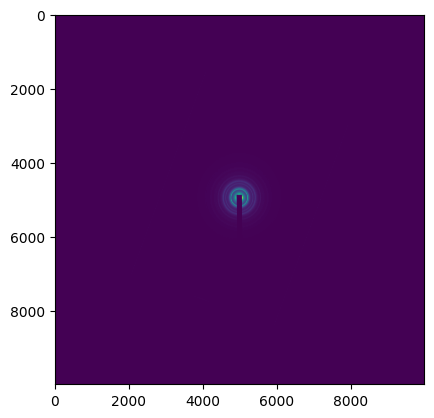

In [141]:
import cv2

M_semi = cv2.getRotationMatrix2D((round(data_for_rot.shape[0]/2), round(data_for_rot.shape[1]/2)), orientation, 1.0)
semi_rotated = cv2.warpAffine(data_for_rot.copy(), M_semi, data_for_rot.shape)

plt.imshow(semi_rotated)

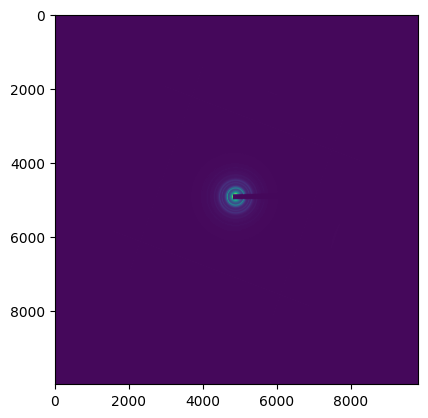

In [142]:
semi_corrected = cv2.resize(semi_rotated, (round(semi_rotated.shape[0]*sc_fac), semi_rotated.shape[1]), interpolation=cv2.INTER_CUBIC)

M = cv2.getRotationMatrix2D((round(data_for_rot.shape[0]/2), round(data_for_rot.shape[1]/2)), 90, 1.0)
rotated = cv2.warpAffine(semi_corrected, M, data_for_rot.shape)

corrected = cv2.resize(rotated, (round(rotated.shape[0]/sc_fac), rotated.shape[1]), interpolation=cv2.INTER_CUBIC)

plt.imshow(corrected)

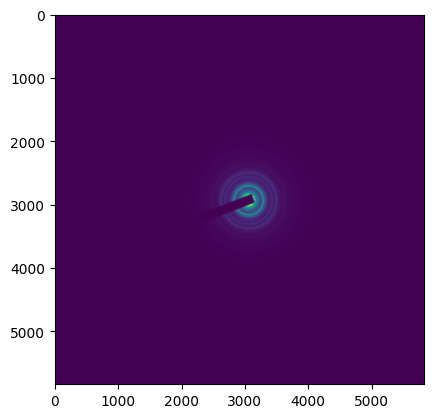

In [143]:
M_final = cv2.getRotationMatrix2D((round(data_for_rot.shape[0]/2), round(data_for_rot.shape[1]/2)), -(orientation+90), 1.0)
final_al = cv2.warpAffine(corrected.copy(), M_final, data_for_rot.shape)

final = final_al[l:l+data8.shape[0], l:l+data8.shape[0]]

plt.imshow(final)

# for testing

In [144]:
img_padder.square_data = final

data = img_padder.recover_original_data().copy()

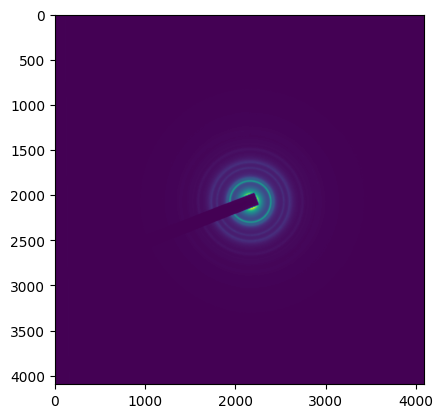

In [149]:
plt.imshow(data)